<a href="https://colab.research.google.com/github/ankitrajput77/Deep_Learning_For_Computer_Vision/blob/main/03_Malaria_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malaria detection using CNN

In [72]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import InputLayer, Dense, MaxPool2D, Flatten, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint


In [2]:
dataset, dataset_info = tfds.load('malaria', with_info=True, # info generator
                                  as_supervised=True, # want (image, label)
                                  shuffle_files = True, # shuffled the train data
                                  split=['train']) # choosing only train data

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteUAKB3O/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
dataset = dataset[0]

In [4]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [5]:
for image, label in dataset:
    print((image, label))
    break

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


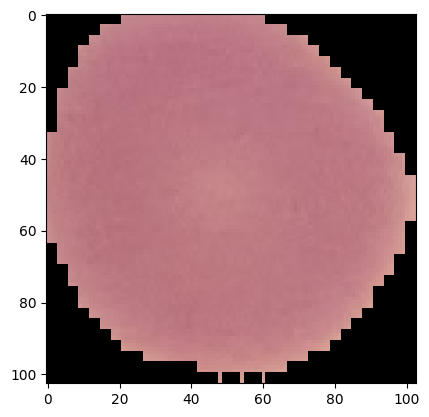

In [6]:
plt.imshow(image, cmap='gray')

In [7]:
label.numpy()

1

In [8]:
len(dataset.skip(5))

27553

In [9]:
len(dataset.take(5))

5

In [10]:
subset_dataset = dataset.take(10)
len(subset_dataset)

10

In [11]:
subset2_dataset = dataset.skip(10)
len(subset2_dataset) # len(dataset) - 10

27548

In [12]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(len(train_dataset))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(len(val_dataset))
  return train_dataset, val_dataset, test_dataset

In [13]:
len(dataset)

27558

In [14]:
train_dataset, val_dataset, test_dataset = splits(dataset, 0.8, 0.1, 0.1)

In [15]:
len(train_dataset), len(val_dataset), len(test_dataset)

(22046, 2755, 2757)

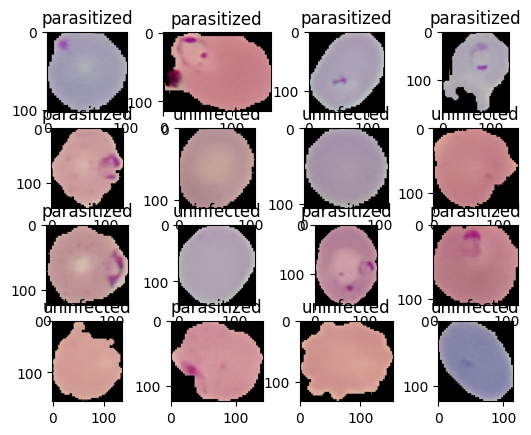

In [16]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image, cmap='gray')
  plt.title(dataset_info.features['label'].int2str(label))

In [17]:
dataset_info.features['label'].int2str(0)

'parasitized'

In [18]:
dataset_info.features['label'].int2str(1)

'uninfected'

In [19]:
def resize(image, label):
  return tf.image.resize(image, [224, 224])/255.0, label

In [20]:
train_dataset = train_dataset.map(resize)
val_dataset = val_dataset.map(resize)
test_dataset = test_dataset.map(resize)

In [21]:
for image, label in train_dataset:
    print((image, label))
    break

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>, <tf.Tensor: shape=(), dtype=int6

In [22]:
label

<tf.Tensor: shape=(), dtype=int64, numpy=1>

In [23]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

# Model

In [24]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(224, 224, 3)),
    Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', activation='sigmoid'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'),
    Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation='sigmoid'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'),
    Flatten(),
    Dense(1000, activation='relu'),
    BatchNormalization(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 batch_normalization (BatchN  (None, 220, 220, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_1 (Batc  (None, 106, 106, 16)     64        
 hNormalization)                                                 
                                                        

In [25]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss= BinaryCrossentropy(),
              metrics=['accuracy'])

In [26]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=1, verbose=1)

689/689 [==============================] - 92s 114ms/step - loss: 0.5142 - accuracy: 0.7475 - val_loss: 1.5010 - val_accuracy: 0.5768


<Axes: >

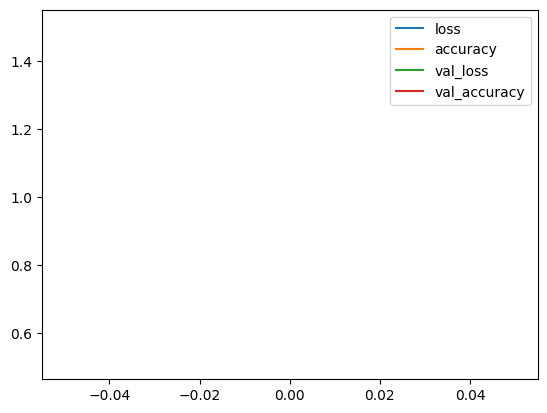

In [27]:
pd.DataFrame(history.history).plot()

In [28]:
test_dataset = test_dataset.batch(1)

In [29]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [30]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 33s 4ms/step - loss: 1.5218 - accuracy: 0.5811


[1.5218154191970825, 0.581066370010376]

In [31]:
model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 12s 12s/step


0.9997054

In [32]:
def check(x):
  if x < 0.5 :
    return str('p')
  else:
    return str('u')

1/1 [==============================] - 0s 18ms/step


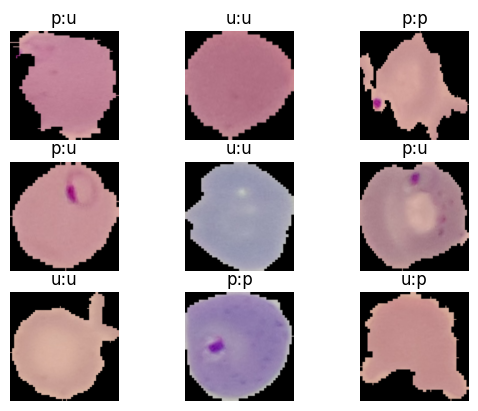

In [33]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image[0])
  plt.title(str(check(label.numpy()[0])) + ":" + str(check(model.predict(image)[0][0])))
  plt.axis('off')

In [35]:
model.save('Malaria_Diagnosis_model.h5')

# Functional API

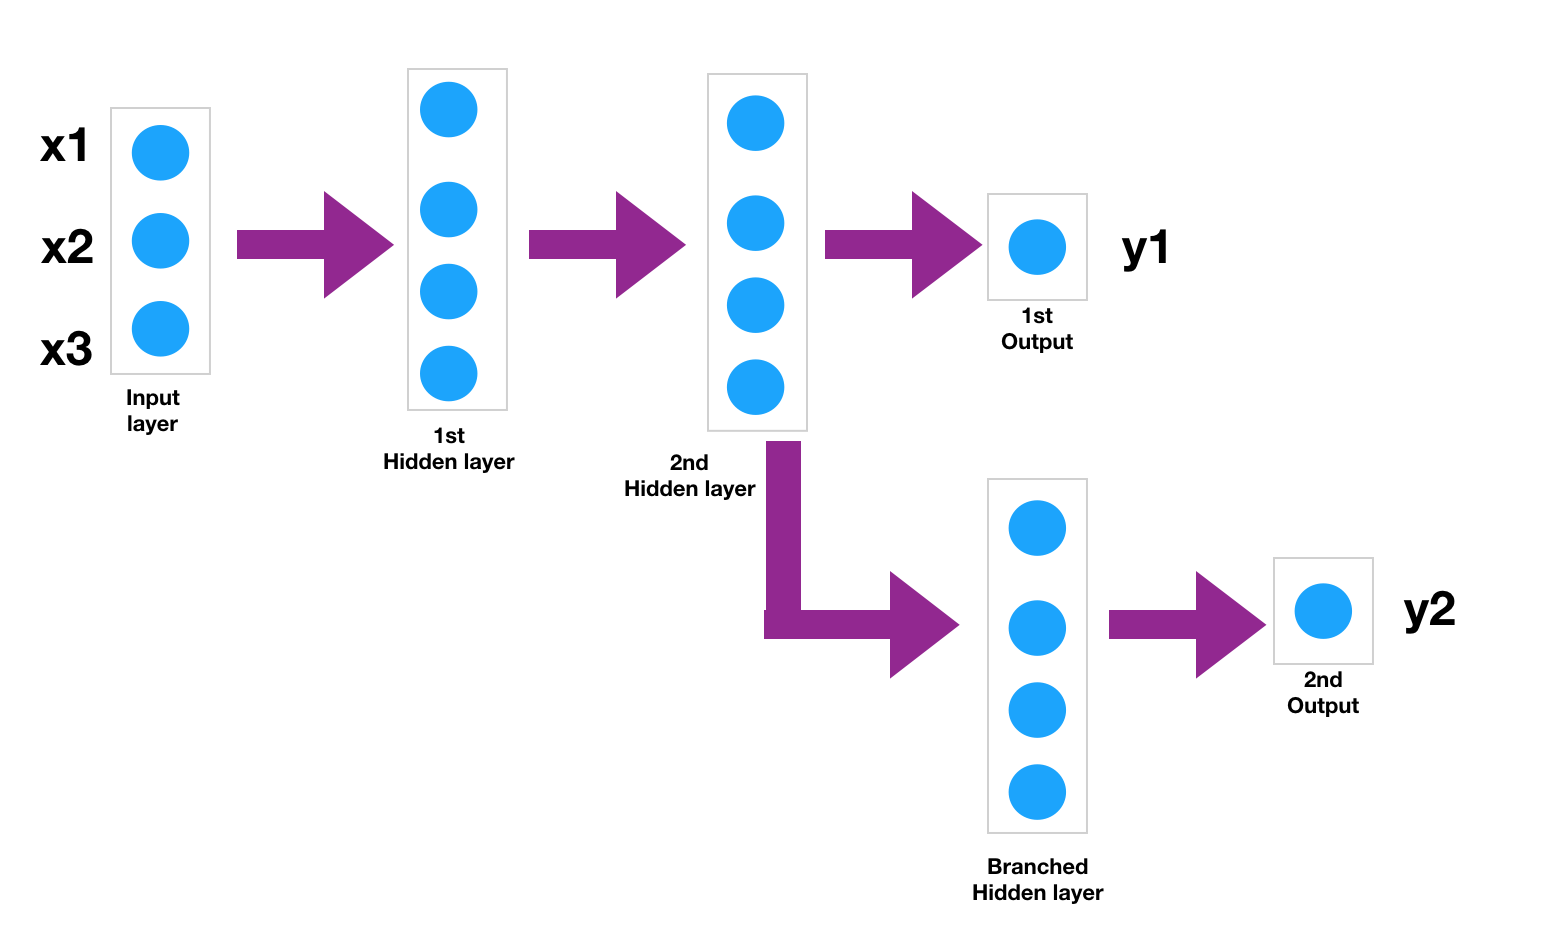

In [36]:
input = Input(shape = (224, 224, 3), name = "Input_Image")

x = Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', activation='sigmoid')(input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2), strides=2, padding='valid')(x)

x = Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation='sigmoid')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2), strides=2, padding='valid')(x)

x = Flatten()(x)
x = Dense(1000, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(1, activation='sigmoid')(x)


func_model = Model(input, output, name = "func_model")
func_model.summary()

Model: "func_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 220, 220, 6)       456       
                                                                 
 batch_normalization_4 (Batc  (None, 220, 220, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 6)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_5 (Batc  (None, 106, 106, 16)     6

# Model Subclassing

In [37]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

    self.conv_2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

  def call(self, x, training):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x
feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [38]:
func_input = Input(shape = (224, 224, 3), name = "Input Image")

x = feature_sub_classed(func_input) # automatically calling call function iwth func_input

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (FeatureE  (None, 54, 54, 16)       1488      
 xtractor)                                                       
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_10 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 10)                

In [39]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")

  def call(self, x, training):

    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)
    return x

lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1,224,224,3]))
lenet_sub_classed.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featur  multiple                 1488      
 eExtractor)                                                     
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_9 (Dense)             multiple                  4665700   
                                                                 
 batch_normalization_14 (Bat  multiple                 400       
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_15 (Bat  multiple                 

In [40]:
lenet_model_func.compile(optimizer=Adam(learning_rate=0.01),
              loss= BinaryCrossentropy(),
              metrics=['accuracy'])

In [41]:
lenet_sub_classed.compile(optimizer=Adam(learning_rate=0.01),
              loss= BinaryCrossentropy(),
              metrics=['accuracy'])

## Now we can fit these models

# Custom Layer

In [42]:
class NeuralearnDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralearnDense, self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), initializer = "random_normal", trainable = True)
    self.b = self.add_weight(shape = (self.output_units,), initializer = "random_normal", trainable = True)

  def call(self, input_features):

    pre_output = tf.matmul(input_features, self.w) + self.b

    if(self.activation == "relu"):
      return tf.nn.relu(pre_output)

    elif(self.activation == "sigmoid"):
      return tf.math.sigmoid(pre_output)

    else:
      return pre_output

In [43]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
            BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [44]:
lenet_model_func.compile(optimizer=Adam(learning_rate=0.01),
              loss= BinaryCrossentropy(),
              metrics=metrics)

In [45]:
history = lenet_model_func.fit(train_dataset, validation_data=val_dataset, epochs=1, verbose=1)

689/689 [==============================] - 54s 70ms/step - loss: 0.3957 - tp: 9089.0000 - fp: 2116.0000 - tn: 8905.0000 - fn: 1936.0000 - accuracy: 0.8162 - precision: 0.8112 - recall: 0.8244 - auc: 0.9016 - val_loss: 0.2771 - val_tp: 1367.0000 - val_fp: 231.0000 - val_tn: 1132.0000 - val_fn: 25.0000 - val_accuracy: 0.9071 - val_precision: 0.8554 - val_recall: 0.9820 - val_auc: 0.9650


In [46]:
history.history

{'loss': [0.3957158625125885],
 'tp': [9089.0],
 'fp': [2116.0],
 'tn': [8905.0],
 'fn': [1936.0],
 'accuracy': [0.8162024617195129],
 'precision': [0.8111557364463806],
 'recall': [0.8243991136550903],
 'auc': [0.9016047120094299],
 'val_loss': [0.27712029218673706],
 'val_tp': [1367.0],
 'val_fp': [231.0],
 'val_tn': [1132.0],
 'val_fn': [25.0],
 'val_accuracy': [0.9070780277252197],
 'val_precision': [0.8554443120956421],
 'val_recall': [0.9820402264595032],
 'val_auc': [0.9650159478187561]}

In [47]:
labels = []
inp = []
# for t in test_dataset:
#   print(t)
#   break
for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [48]:
print(np.array(inp).shape)
print(np.array(inp)[:,0,...].shape)

(2757, 1, 224, 224, 3)
(2757, 224, 224, 3)


In [49]:
labels = np.array([i[0] for i in labels])
print(labels)

[1 0 0 ... 1 1 0]


In [50]:
predicted = lenet_model_func.predict(np.array(inp)[:,0,...])
print(predicted[:,0])

87/87 [==============================] - 1s 15ms/step
[0.9888418  0.18367301 0.09031151 ... 0.9838525  0.9792637  0.00559026]


[[1167  231]
 [  26 1333]]


Text(0.5, 58.7222222222222, 'Predicted')

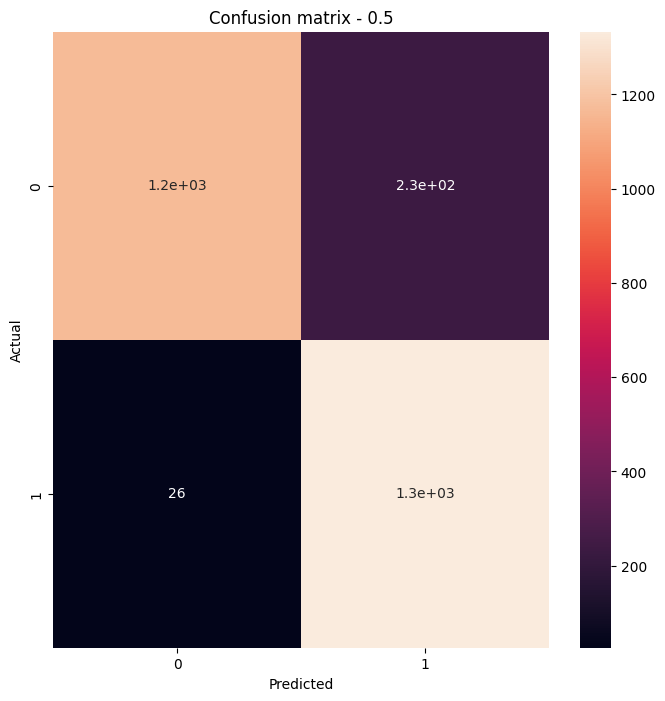

In [51]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

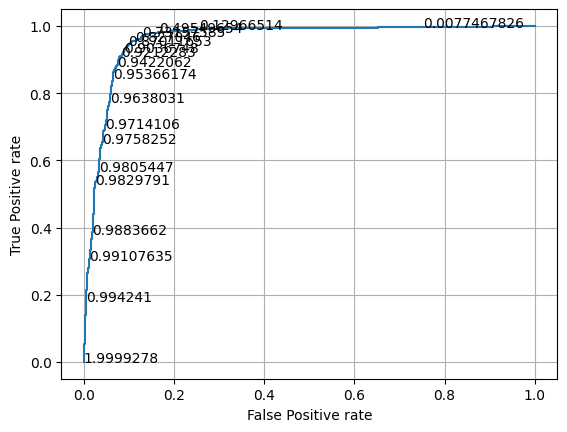

In [52]:
fp, tp, thresholds = roc_curve(labels, predicted)
plt.plot(fp, tp)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")

plt.grid()

skip = 20

for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])

plt.show()

# Callback

In [58]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\nfor epoch number {} we have loss {}".format(epoch+1, logs['loss']))
  def on_batch_end(self, batch, logs):
    print("\nfor batch number {} we have loss {}".format(batch+1, logs['loss']))


In [74]:
history = lenet_model_func.fit(train_dataset, validation_data=val_dataset, epochs=2, verbose=1, callbacks=[LossCallback(), csv_callback, earlystopping, scheduler_callback, model_checkpoint_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/2

for batch number 1 we have loss 0.002946509514003992
  1/689 [..............................] - ETA: 4:01 - loss: 0.0029 - tp: 15.0000 - fp: 0.0000e+00 - tn: 17.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
for batch number 2 we have loss 0.025965772569179535
  2/689 [..............................] - ETA: 1:19 - loss: 0.0260 - tp: 30.0000 - fp: 0.0000e+00 - tn: 32.0000 - fn: 2.0000 - accuracy: 0.9688 - precision: 1.0000 - recall: 0.9375 - auc: 1.0000    
for batch number 3 we have loss 0.03585745021700859
  3/689 [..............................] - ETA: 1:20 - loss: 0.0359 - tp: 45.0000 - fp: 1.0000 - tn: 48.0000 - fn: 2.0000 - accuracy: 0.9688 - precision: 0.9783 - recall: 0.9574 - auc: 0.9991    
for batch number 4 we have loss 0.06820245087146759
  4/689 [..............................] - ETA: 1:24 - loss: 0.0682 - tp: 63.0000 - fp: 2.0000 - tn: 60.

In [61]:
import tensorflow as tf
csv_callback = tf.keras.callbacks.CSVLogger(
    'logs.csv', separator=',', append = False
)

In [66]:
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    start_from_epoch=0
)

In [64]:
earlystopping

In [70]:
def scheduler(epoch, lr):
  if epoch <= 1:
    learning_rate = lr
  else:
    learning_rate = lr * tf.math.exp(-0.1)
    learning_rate = learning_rate.numpy()

  with train_writer.as_default():
    tf.summary.scalar('Learning Rate', data = learning_rate, step = epoch)
  return learning_rate

train_writer = tf.summary.create_file_writer('logs')
scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

In [73]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)